# Probabilistic PCA

We first review standard PCA, and motivate the requirement for a probabilistic view.

We generatively model the PCA problem, and discuss solving this problem using the EM algorithm.

Most of the ideas in this notebook are borrowed from PRML Bishop.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

rng = np.random.default_rng(seed=12)

# PCA Review

**Use cases** | **Methodology**
--|--
Analyze data and extract variables with similar concepts (principal components) | Maximizing variance of the projecred dataset $\mathbf{X}$
Project the data onto a lower dimensional space | Represent $\mathbf{X}$ in a different space spanned by an orthonormal basis $\mathbf{W}$ - where columns of $\mathbf{W}$ correspond to the eigenvectors of $\mathbf{X}$
Principal components that capture greater variance (equivalent to corresponding eigenvalue) are considered more important | Considering likelihood to be the reconstruction error and calculating Maximum-Likelihood estimators


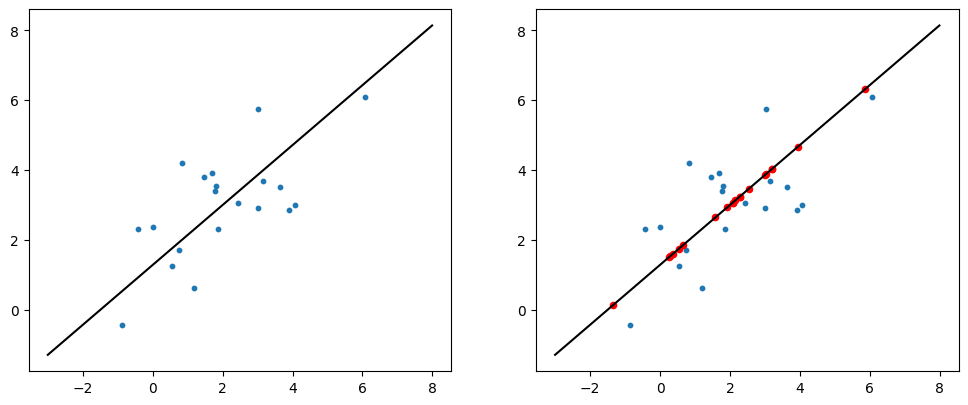

In [7]:
X = rng.multivariate_normal((2, 3), [[5, 3], [3, 3]], size=20)

# Perform PCA on X

plt.figure(figsize=(12, 5))

X_mean = X.mean(axis=0)

X_centered = X - X_mean
cov_X = np.cov(X_centered.T)
eig_val, eig_vec = np.linalg.eigh(cov_X)
pc_vec = eig_vec[:,-1] / eig_vec[:,-1][0]
x_range = np.array([-5, 6])

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], s=10);
plt.plot(x_range + X_mean[0], x_range * pc_vec[1] + X_mean[1], color='black')
plt.axis('scaled')

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], s=10);
X_proj = np.array([i * eig_vec[:, -1] + X_mean for i in X_centered @ eig_vec[:, -1]])
plt.scatter(X_proj[:, 0], X_proj[:, 1], s=20, color='red');
plt.plot(x_range + X_mean[0], x_range * pc_vec[1] + X_mean[1], color='black')
plt.axis('scaled')

plt.show()

# Probabilistic PCA

Reformulation of PCA in a probabilistic form, brings several advantages over conventional PCA:

- An EM algorithm for PCA can be derived that is efficient when only a few leading eigenvectors are needed, and it avoids the need to evaluate the data covariance matrix.
- The combination of a probabilistic model and EM can handle missing values in the dataset.
- Mixtures of probabilistic PCA models can be systematically formulated and trained using the EM algorithm.
- The existence of a likelihood function allows for direct comparison with other probabilistic density models. For example, if there is an outlier-like point that is far away from the training set however is close to a principal component, then conventional PCA will assign a lower reconstruction cost.
- The probabilistic PCA model can be used generatively to produce samples from the distribution.

## Generative Modelling

In generative modelling, we try to induce a latent variable $\mathbf{Z}$ of a lower dimension, which will help represent high-dimensional variable $\mathbf{X}$.

In the context of PCA, $\mathbf{Z}$ will represent the mappings of $\mathbf{X}$ on a lower dimensional subspace, which corresponds to the principal subspace.

So how do we introduce $\mathbf{Z}$?

### A generative story

Let $L$ and $D$ be the dimension of the latent space $\mathbf{Z}$ and data space $\mathbf{X}$ respectively.

The following steps are followed to generate a new sample $\mathbf{x}$:

- Sample $\mathbf{z}$ from the prior defined as  $p(\mathbf{z}) = \mathcal{N}(\mathbf{z}|0, \mathbf{I})$
- Further, sample $\mathbf{x}$ using $\mathbf{z}$ from the conditional distribution  $p(\mathbf{x}|\mathbf{z}) = \mathcal{N}(\mathbf{x}|\mathbf{W}\mathbf{z}+\mathbf{\mu}, σ^2\mathbf{I})$

We require $\mathbf{W}$ to span a linear subspace, corresponding to the principal subspace of $\mathbf{X}$.

We illustrate this below for the simple case where $D=2, L=1$. We obtain parameter values for the distribution from PCA performed above in the notebook. We see that the dataset can effectively be regenerated after estimating parameters of our model.


In [8]:
#| column: screen

from IPython.display import HTML
from matplotlib import animation

M, N = np.mgrid[-6:10:0.1, -6:10:0.1]
grid = np.dstack((M, N))

x = np.linspace(-4, 4)
z = rng.standard_normal()
w = pc_vec/np.sqrt(pc_vec.T@pc_vec)
n, d = X.shape

mu = X.mean(axis=0)
s2 = eig_val[0]
X_gen = []

theta = np.linspace(0, 2*np.pi, 1000)
circle = np.c_[np.cos(theta), np.sin(theta)]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
norm_pdf = ax1.plot(x, norm.pdf(x, 0, 1))
ax2_line = ax2.plot(x_range + X_mean[0], x_range * pc_vec[1] + X_mean[1], color='black')

# zeroth frame - pdf, line graph
default = norm_pdf + ax2_line
artists = [list(default)]

for _ in range(15):
  # sampling x
  x_mean = np.expand_dims(z*w+mu, -1).T
  x = rng.multivariate_normal(z*w+mu, cov=s2*np.eye(2))

  frame = list(default)

  # first frame - sample z
  z = rng.standard_normal()
  frame.append(ax1.scatter(z, 0, marker='x', color='red'))

  artists.append(list(frame))

  # second frame - visualize p(x|z)
  frame += ax2.plot((x_mean + 0.5*s2*circle)[:, 0], (x_mean + 0.5*s2*circle)[:, 1], color='red')
  frame += ax2.plot((x_mean + 1*s2*circle)[:, 0], (x_mean + 1*s2*circle)[:, 1], color='red')
  frame += ax2.plot((x_mean + 1.5*s2*circle)[:, 0], (x_mean + 1.5*s2*circle)[:, 1], color='red')

  artists.append(list(frame))

  # third frame - sample x, show collection
  frame.append(ax2.scatter(x[0], x[1], color='orange', marker='x'))
  new_point_plot = ax3.scatter(x[0], x[1], color='orange', s=10)
  frame.append(new_point_plot)
  artists.append(list(frame))

  # preserve new point by incrementing default collection
  default.append(new_point_plot)

else:
  frame = list(default)
  probability_grid = multivariate_normal(X.mean(axis=0), w@w.T + s2*np.eye(d)).pdf(grid)
  frame += ax2.contour(M, N, probability_grid).collections
  frame += ax3.contour(M, N, probability_grid).collections

artists.append(list(frame))

plt.close()
ax3.sharex(ax2);
ax3.sharey(ax2);
ax2.axis('scaled');ax3.axis('scaled');

ax1.title.set_text('Sampling z from latent space')
ax2.title.set_text('Sampling x from data space')
ax3.title.set_text('Collection of sampled points')

anim = animation.ArtistAnimation(fig, artists, interval=600, repeat=False, blit=False);
HTML(anim.to_jshtml())

In the final frame of the above animation, we see that the genrative story effectively reduces to the sampling of $\mathbf{X}$ from the following distribution:
$$
\begin{alignat}{2}
&& p(\mathbf{x}) &= \int{p(\mathbf{x}|\mathbf{z})p(\mathbf{z}) d\mathbf{z}} \\
&& &= \mathcal{N}(\mathbf{x}|\mathbf{\mu}, \mathbf{W}\mathbf{W}^T + σ^2\mathbf{I})
\end{alignat}
$$

The above derivation is easy by noting that $p(\mathbf{x})$ is gaussian. So one can just find the mean and covariance:

$$
\begin{aligned}
\mathbb{E}[\mathbf{x}] & =\mathbb{E}[\mathbf{W} \mathbf{z}+\mu+\epsilon]=\mu \\
\operatorname{cov}[\mathbf{x}] & =\mathbb{E}\left[(\mathbf{W} \mathbf{z}+\epsilon)(\mathbf{W} \mathbf{z}+\epsilon)^T\right] \\
& =\mathbb{E}\left[\mathbf{W} \mathbf{z z}^{\mathbf{T}} \mathbf{W}^{\mathbf{T}}\right]+\mathbb{E}\left[\epsilon \epsilon^{\mathbf{T}}\right]=\mathbf{W} \mathbf{W}^{\mathbf{T}}+\sigma^2 \mathbf{I}
\end{aligned}
$$

# EM for Probablistic PCA

The data log-likelihood of our model can be written as follows:

$$\ln p\left(\mathbf{X}, \mathbf{Z} \mid \boldsymbol{\mu}, \mathbf{W}, \sigma^2\right)=\sum_{n=1}^N\left\{\ln p\left(\mathbf{x}_n \mid \mathbf{z}_n\right)+\ln p\left(\mathbf{z}_n\right)\right\}$$

Maximizing the above function is a little complex, but closed-form solutions do exist for the ML estimators. We will, however, follow an iterative approach by formulating an EM Algorithm:

## E-step

The E-step estimates the conditional distribution of the hidden variables $\mathbf{Z}$ given the data $\mathbf{X}$ and the current values of the model parameters $\mathbf{W, σ^2}$ (note that ML estimate of $\mathbf{\mu}$ is simply the sample mean $\mathbf{\overline{X}}$, so it can simly be mean-centered in the preprocessing step)

$$
\begin{alignat}{2}
Σ_\mathbf{Z} &= σ^2(σ^2\mathbf{I}+\mathbf{W^T W})^{-1}, \\
\mathbf{Z} &= \frac{1}{σ^2}Σ_\mathbf{Z}\mathbf{W}^T\mathbf{Y}
\end{alignat}
$$

## M-step

The M-Step re-estimates the model paramters as

\begin{aligned}
\mathbf{W} & =\mathbf{Y} {\mathbf{Z}}^{\mathrm{T}}\left({\mathbf{Z Z}}^{\mathrm{T}}+n \Sigma_{\mathbf{Z}}\right)^{-1}, \\
σ^2 & =\frac{1}{ND} \sum_{i=1}^d \sum_{j=1}^n\left(y_{i j}-\mathbf{w}_i^{\mathrm{T}} {\mathbf{z}}_j\right)^2+\frac{1}{d} \operatorname{tr}\left(\mathbf{W} \Sigma_{\mathbf{Z}} \mathbf{W}^{\mathrm{T}}\right) .
\end{aligned}



In [9]:
# Initialization
X_ = (X-X.mean(axis=0)).T
W = np.array([[1, -1]]).T
s2 = 0.1

artists = []
fig, ax = plt.subplots(dpi=150)
ax.sharex(ax2)
ax.sharey(ax2)

default = [ax.scatter(X[:, 0], X[:, 1], s=10)]

for _ in range(7):
  frame = list(default)
  pc = W.T[0]/W.T[0][0]
  probability_grid = multivariate_normal(X.mean(axis=0), W@W.T + s2*np.eye(d)).pdf(grid)

  frame += ax.contour(M, N, probability_grid).collections
  frame +=  ax.plot(x_range + X_mean[0], x_range * pc[1] + X_mean[1], color='black')

  # E-step
  cov_Z = s2*np.linalg.inv(s2*np.eye(W.shape[1]) + W.T@W)
  Z = cov_Z*W.T@X_ / s2

  # M-step
  W = X_@Z.T@np.linalg.inv(Z@Z.T + X_.shape[1]*cov_Z)
  s2 = ((X_-W@Z)**2).sum()/(n*d) + np.trace(W@cov_Z@W.T)/d
  artists.append(frame)

plt.close()
anim = animation.ArtistAnimation(fig, artists, interval=500, repeat=False, blit=False);
HTML(anim.to_jshtml())

# EM for Standard PCA

In the above probabilistic formulation, if we take the limit $σ^2→0$ we end up again in standard PCA. However, the EM algortihm simplifies nicely, giving the following elegant algorithm:

$$
\begin{aligned}
\text{E-Step: }\\
\mathbf{Z} &= (\mathbf{W^T W})^{-1}\mathbf{W}^T\mathbf{X}\\
\text{M-Step: }\\
\mathbf{W} &= \mathbf{X}^T\mathbf{Z}^T(\mathbf{ZZ}^T)^{-1}
\end{aligned}
$$

- The **E-Step** is just an orthogonal projection of the data.
- The **M-Step** corresponds to a multi-output linear regression where $\mathbf{Z}$ from E-Step acts as the features, and $\mathbf{X}$ the labels.

In [10]:
# Initialization
X_ = (X-X.mean(axis=0)).T
W = np.array([[1, -1]]).T
s2 = 0.1

M, N = np.mgrid[-6:10:0.1, -6:10:0.1]
grid = np.dstack((M, N))

d, n = X_.shape

artists = []
fig, ax = plt.subplots(dpi=150)

default = [ax.scatter(X[:, 0], X[:, 1], s=10)]

for _ in range(5):
  frame = list(default)
  pc = W.T[0]/W.T[0][0]
  w_ortho = pc/np.linalg.norm(pc)
  ortho_points = np.array([i * w_ortho for i in X_.T @ w_ortho])

  frame +=  ax.plot(x_range + X_mean[0], x_range * pc[1] + X_mean[1], color='black')
  for i, j in zip(X, ortho_points):
    frame += ax.plot([i[0], j[0]+X_mean[0]], [i[1], j[1]+X_mean[1]], color='red')

  artists.append(frame)
  frame = list(default)

  # E-step
  Z = np.linalg.inv(W.T@W)*W.T@X_
  # M-step
  W = X_@Z.T@np.linalg.inv(Z@Z.T)

  pc = W.T[0]/W.T[0][0]
  w_ortho_new = pc/np.linalg.norm(pc)
  alpha = np.arccos(w_ortho.T@w_ortho_new)

  rot = np.array([[np.cos(alpha), np.sin(alpha)], [-1*np.sin(alpha), np.cos(alpha)]])
  released_points = ortho_points@rot

  frame += ax.plot(x_range + X_mean[0], x_range * pc[1] + X_mean[1], color='black')
  for i, j in zip(X, released_points):
    frame += ax.plot([i[0], j[0]+X_mean[0]], [i[1], j[1]+X_mean[1]], color='red')

  artists.append(frame)

ax.axis('equal')
plt.close()
anim = animation.ArtistAnimation(fig, artists, interval=500, repeat=False, blit=False);
HTML(anim.to_jshtml())

The above animation also illustrates a simple physical analogy for PCA using EM, for the case when $D=2$ and $L=1$:
- In the E-step, we attach the data to a rigid fixed rod with direction $\mathbf{w}$ orthogonally using a spring that obeys Hooke's law
- In the M-step, keeping the attachments fixed, we release the rod and allow it to minimize spring energy.

The alternating of the above 2 steps corresponds to the EM algorithm for conventional PCA.